#MTBI Analysis

##Introduction
In this analysis, a Meyers-Briggs Classification is performed based on the comment posts found on the internet. The data was imported from [kaggle.com](kaggle.com/datasets/datasnaek/mbti-type), with labels, processed using RNN with Gated Reccurrent Units (GRU).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
%ls *

'Colab Notebooks'/   MLData/   modules/


In [ ]:
import sys
sys.path.append('MyDrive')
sys.path.append("MyDrive/modules")
print (sys.path)


['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', 'MyDrive', 'MyDrive/modules']


In [ ]:
from mbti_utils import *
# %load_ext autoreload
# %autoreload 2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Preprocessing

In [ ]:
#Input
dataset =pd.read_csv("MyDrive/MLData/mbti_1.csv")
print('\n\n')
print(dataset.head(),'\n')
print(dataset.info(),'\n')

#Get Uniques Labels
unq_types = pd.unique(dataset['type'])
grouped_dt= dataset.groupby(['type']).size().reset_index()
grouped_dt.columns = ['type','Count']
grouped_dt = grouped_dt.sort_values('Count',ascending=True)
print("Uniques Labels:",len(unq_types),'\n',unq_types)




   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce... 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB
None 

Uniques Labels: 16 
 ['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


Here, Data contains 16 unique labels. ***We have performed a 16 class classification, as well as a simplified binary classification between introvert and extrovert***. This is useful because
1. number of comments in each category are not equal and many classes contain few comments, compared to a larger introvert/extrovert category 

2. simplified categories are easier to understand than the specialized ones.



###Hyperparameters

In [ ]:
#Hyperparameters
vocab_size    = 10000
nlabels       = len(unq_types)
embedding_dim = 128
gru_units     = 128
nepochs       = 3

**Convert the sentences -> words -> useful words vectors (tokens)**

In [ ]:
#Get Posts
posts,labels,labels_dict = getPosts(dataset)
posts = posts  [::20]
labels= labels [::20]
#Tokenize
posts_tk, max_seq \
         = tokenize(posts,vocab_size=vocab_size)
labels_tk= np.array([labels_dict[i] for i in labels])
l_tmp = []
for i in labels:
    if i[0]=='E': l_tmp.append(0)
    if i[0]=='I': l_tmp.append(1)
    else        : assert("Wrong Label")
labels_binary = np.array(l_tmp)
print ("Posts  shape:", posts_tk.shape)
print ("Labels shape:",labels_tk.shape,labels_binary.shape)
print(10*"--")

411188 posts added.
Starting tokenizer
-------------------- 
 Max Sequence Length 199
Median Sequence Length 107.0
Vocab Size 10000
41119 tokenized
Posts  shape: (41119, 199)
Labels shape: (41119,) (41119,)
--------------------


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text major ticklabel objects>)

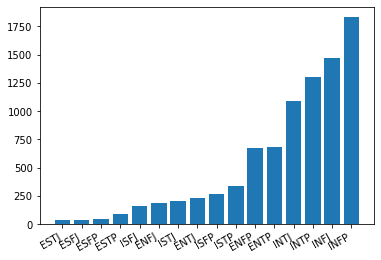

In [ ]:
#Plot Class Occ
plt.bar(grouped_dt.type,grouped_dt.Count)
plt.xticks(rotation=30,ha='right')

**Uneven observation across classes (above)**

(array([1.030e+02, 3.060e+02, 3.750e+02, 2.600e+02, 3.660e+02, 3.710e+02,
        4.140e+02, 4.240e+02, 4.250e+02, 4.300e+02, 4.280e+02, 4.290e+02,
        4.270e+02, 4.060e+02, 4.320e+02, 4.380e+02, 4.110e+02, 4.180e+02,
        3.880e+02, 3.890e+02, 3.830e+02, 3.870e+02, 3.640e+02, 3.600e+02,
        3.730e+02, 3.380e+02, 3.370e+02, 3.350e+02, 3.450e+02, 3.530e+02,
        3.160e+02, 3.220e+02, 3.040e+02, 2.990e+02, 3.190e+02, 2.850e+02,
        2.750e+02, 3.000e+02, 2.690e+02, 2.920e+02, 2.920e+02, 3.040e+02,
        2.820e+02, 3.150e+02, 3.370e+02, 3.600e+02, 3.820e+02, 4.040e+02,
        5.390e+02, 2.390e+02, 6.280e+02, 6.720e+02, 7.640e+02, 9.230e+02,
        1.043e+03, 1.143e+03, 1.182e+03, 1.296e+03, 1.347e+03, 1.411e+03,
        1.402e+03, 1.389e+03, 1.304e+03, 1.258e+03, 1.190e+03, 1.100e+03,
        9.500e+02, 8.650e+02, 7.120e+02, 6.180e+02, 4.380e+02, 4.000e+02,
        3.120e+02, 2.440e+02, 2.170e+02, 1.460e+02, 1.020e+02, 6.400e+01,
        6.800e+01, 5.300e+01, 4.400e+0

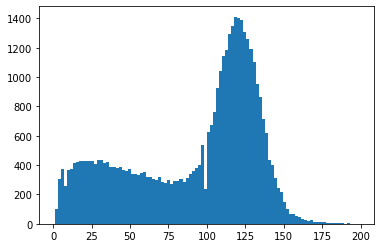

In [ ]:
#Plot Text Lengths
plt.hist([len(i) for i in posts], bins=100)

##Train Test Datasets

**The tokenized data is converted into useful embeddings and passed to GRU model defined in `mtbi_utils.py`. Two models are tested: multi-class model and binary model.**

In [ ]:
#Train Test Datasets
from sklearn.model_selection import train_test_split
#Binary classification I vs E
train_X, test_X, train_y, test_y = train_test_split(\
                                posts_tk, labels_binary, test_size=0.2,random_state=0)
#Multi-class - 16 classes
train_X_2, test_X_2, train_y_2, test_y_2 = train_test_split(\
                                posts_tk, labels_tk, test_size=0.2,random_state=0)

#Model Binary Classification 
model = makeModel(vocab_size,max_seq,embedding_dim,gru_units)
model.compile(
        optimizer='adam',
        loss     ='binary_crossentropy',
        metrics  = ['accuracy',tf.keras.metrics.AUC(name='auc')]
)
history_binary = model.fit(train_X,train_y,
                    validation_split= 0.2,
                    batch_size      = 32,
                    epochs          = nepochs,
            )

Epoch 1/3
823/823 [==============================] - 322s 386ms/step - loss: 0.5513 - accuracy: 0.7647 - auc: 0.5054 - val_loss: 0.5396 - val_accuracy: 0.7696 - val_auc: 0.5052
Epoch 2/3
823/823 [==============================] - 321s 390ms/step - loss: 0.5481 - accuracy: 0.7655 - auc: 0.5067 - val_loss: 0.5616 - val_accuracy: 0.7697 - val_auc: 0.5074
Epoch 3/3
823/823 [==============================] - 313s 381ms/step - loss: 0.5462 - accuracy: 0.7654 - auc: 0.5173 - val_loss: 0.5424 - val_accuracy: 0.7697 - val_auc: 0.5016


In [ ]:
#Model2 - Multi-class classification
model2 = makeModel(vocab_size,max_seq,embedding_dim, gru_units, makeBinary=False)
model2.compile(
                optimizer='adam',
                loss     ='categorical_crossentropy',
                metrics  = ['accuracy',tf.keras.metrics.AUC(name='auc')]
)

train_y_2_1h = convert_to_one_hot(train_y_2,nlabels)
history_multiclass = model2.fit(train_X_2,train_y_2_1h,
                        validation_split = 0.2,
                        batch_size       =  32,
                        epochs           =  nepochs,
            )


[1 1 0 ... 3 6 0]
16
Epoch 1/3
823/823 [==============================] - 324s 388ms/step - loss: 2.3070 - accuracy: 0.1980 - auc: 0.7817 - val_loss: 2.3139 - val_accuracy: 0.1716 - val_auc: 0.7811
Epoch 2/3
823/823 [==============================] - 318s 386ms/step - loss: 2.2941 - accuracy: 0.2020 - auc: 0.7846 - val_loss: 2.2954 - val_accuracy: 0.2082 - val_auc: 0.7843
Epoch 3/3
823/823 [==============================] - 316s 384ms/step - loss: 2.2886 - accuracy: 0.2033 - auc: 0.7857 - val_loss: 2.3086 - val_accuracy: 0.2017 - val_auc: 0.7816


##Plot

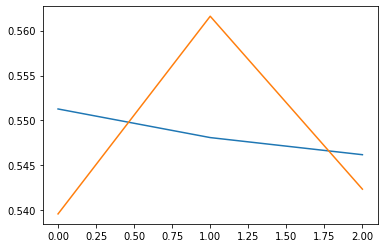

In [ ]:
import seaborn as sns 
train_loss= history_binary.history['loss']
train_acc = history_binary.history['accuracy']
val_loss  = history_binary.history['val_loss']
val_acc   = history_binary.history['val_accuracy']

xepoch = range(0,len(train_loss))
sns.lineplot(x=xepoch,y=train_loss)
sns.lineplot(x=xepoch,y=val_loss)

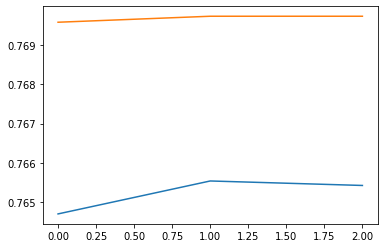

In [ ]:
sns.lineplot(x=xepoch,y=train_acc)
sns.lineplot(x=xepoch,y=val_acc)

# Conclusions
1. A range of vocabulary sizes for tokenization, embedding sizes, and gru units were tested. We found that vocab \~ 10000, and embedding and gru units \~100 were sufficient.
2. A multi-class model does not perform well with accuracy around 20\%. A simpler binary classifier works better at nearly 80\% accuracy. 
3. Adding epochs and gru units did not improve result, which shows the limit of applying this model to the problem.